## Example: Single Index Models and Minimum Variance Portfolio Allocation
In this example, we will use single index models to construct a minimum variance portfolio from a set of risky assets. 

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct SIM-based covariance matrices__ by computing portfolio covariance using beta coefficients and market variance rather than direct estimation from historical returns data.
> * __Compute efficient frontiers__ using both data-driven and single index model approaches, comparing the risk-return tradeoffs produced by each methodology.
> * __Compare portfolio allocations__ between data-driven and SIM-based optimization, analyzing how model simplification affects asset weights and portfolio composition.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` until `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [6]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "INFO" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [8]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [10]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable:

In [12]:
list_of_tickers = keys(dataset) |> collect |> sort;

Next, we'll compute the growth rate matrix for all firms in the dataset. We've implemented [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.log_growth_matrix) which takes the cleaned dataset and a list of ticker symbols, and returns the growth rate array. Each row of the growth rate array is a time step, while each column corresponds to a firm from the `list_of_tickers::Array{String,1}` array.

We'll save this data in the `growth_rate_array::Array{Float64,2}` variable:

In [14]:
growth_rate_array = let

    # initialize -
    r̄ = 0.0; # assume the risk-free rate is 0
    Δt = 1.0/252.0; # assume daily trading (252 trading days in a year)

    # compute the growth matrix -
    growth_rate_array = log_growth_matrix(dataset, list_of_tickers, Δt = Δt, 
        risk_free_rate = r̄); # other optional parameters are at their defaults

    growth_rate_array; # return
end;

Next, let's load the covariance matrix that we computed in the previous example. We'll store this data in the `covariance_dictionary::Dict{String,Any}` variable:

In [16]:
covariance_dictionary = let

    # initialize -
    path_to_covariance = joinpath(_PATH_TO_DATA,"Covariance-Return-Training-Fall-2025.jld2");
    covariance = JLD2.load(path_to_covariance);
    covariance;
end;

Next, let's load the single asset geometric Brownian motion (SAGBM) parameters, which include the drift and diffusion coefficients for each ticker. We'll store this data in the `parameters_df::DataFrame` variable:

In [18]:
parameters_df = let

    # load -
    df = CSV.read(joinpath(_PATH_TO_DATA,"SAGBM-Parameters-Fall-2025.csv"), DataFrame);
    df; # return
end;

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable:

In [20]:
sim_model_parameters = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    sim_model_parameters["data"]; # return
end;

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [22]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)

___

## Task 1: Setup Risk and Return Matrices
In this task, we will set up the risk and return matrices that we will use in the minimum variance portfolio allocation. We'll do two versions: one using a pure data driven approach and another using the single index model parameters.

Let's start by specifying a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers::Array{String,1}` array.

In [25]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "NVDA", "GS", "BAC", "WFC", 
    "C", "F", "GM", "JNJ"]; # random tickers that I selected.

### Data-Driven Risk and Return Matrices
Now that we have selected the firms in our risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix. We'll store these in the `μ̂_data::Array{Float64,1}` and `Σ̂_data::Array{Float64,2}` variables. 

> __Data driven values:__ For the data driven values, we'll use the expected growth rates that we estimated for our single asset geometric Brownian motion models in the previous example. We'll use the covariance matrix that we computed directly from the growth rate data using the centered growth rates matrix.

So what do we get?

In [27]:
μ̂_data, Σ̂_data = let

    # initialize -
    M = length(my_list_of_tickers); # number of assets in portfolio
    μ = Array{Float64,1}(); # drift vector
    Σᵣ = Array{Float64,2}(undef, M, M); # covariance matrix for *our* portfolio
    tickers_in_parameters = parameters_df[:, :ticker] |> collect; # list of tickers in parameters_df
    covariance_ticker_list = covariance_dictionary["list_of_tickers"] |> collect; # list of tickers in covariance dictionary
    Σ = covariance_dictionary["covariance_matrix"]; # full covariance matrix

    # compute drift vector -
    for ticker ∈ my_list_of_tickers
        i = findfirst(x-> x == ticker, tickers_in_parameters); # find index of ticker in the parameters_df
        push!(μ, parameters_df[i, :drift]); # append drift value to μ
    end

    # compute covariance matrix -
    for i ∈ 1:M
        for j ∈ 1:M
            row_index = findfirst(x-> x == my_list_of_tickers[i], covariance_ticker_list); # find row index in full covariance matrix
            col_index = findfirst(x-> x == my_list_of_tickers[j], covariance_ticker_list); # find column index in full covariance matrix
            Σᵣ[i,j] = Σ[row_index, col_index]; # assign value to Σᵣ
        end
    end

    (μ, Σᵣ); # return
end;

Next, we'll compute the expected growth rate (return) and covariance using a single index model. 

To do this, we need to pull out the growth rate of the market portfolio from `growth_rate_array::Array{Float64,2}`. Look up the index for our market portfolio surrogate `SPY`, then store the growth rate (column from the growth rate array) in the `Gₘ::Array{Float64,1}` variable:

In [29]:
Gₘ = findfirst(x->x=="SPY", list_of_tickers) |> i -> growth_rate_array[:,i];

### SIM-Based Risk and Return Matrices
Now we'll compute the expected return vector and covariance matrix using the single index model. We'll use the SIM formula for expected returns and the SIM-derived covariance structure. Store these in the `μ̂_sim::Array{Float64,1}` and `Σ̂_sim::Array{Float64,2}` variables:

In [31]:
μ̂_sim, Σ̂_sim = let

    # initialize -
    N = length(my_list_of_tickers); # number of assets in portfolio
    μ_sim = Array{Float64,1}(); # drift vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    Ḡₘ = mean(Gₘ); # average market factor -
    σ²ₘ = var(Gₘ); # variance of market factor

    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(μ_sim, Ḡᵢ); # append drift value to μ_sim
    end

    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(my_list_of_tickers)

        ticker_i = my_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(my_list_of_tickers)
            
            ticker_j = my_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (μ_sim, Σ̂_sim*Δt); # return
end;

### Covariance Matrix Comparison
Compare the two covariance matrices below. Are they similar? Why or why not?

> __Think about:__ The SIM covariance matrix has a specific structure where all off-diagonal elements are proportional to $\beta_i\beta_j\sigma_m^2$. This means the model assumes all correlations between assets come through their common exposure to market movements. The data-driven covariance captures all pairwise relationships directly from historical data, including firm-specific correlations that may not be market-related.

In [33]:
Σ̂_sim

13×13 Matrix{Float64}:
 0.061982   0.0318509  0.0327428  …  0.039635   0.0406288  0.0149176
 0.0318509  0.0529216  0.0315759     0.0382225  0.0391808  0.014386
 0.0327428  0.0315759  0.0934778     0.0392928  0.040278   0.0147888
 0.0468707  0.0452003  0.046466      0.0562469  0.0576572  0.02117
 0.048084   0.0463704  0.0476689     0.057703   0.0591498  0.021718
 0.0483635  0.0466399  0.0479459  …  0.0580383  0.0594936  0.0218442
 0.036219   0.0349283  0.0359063     0.0434645  0.0445543  0.016359
 0.0375853  0.0362458  0.0372608     0.045104   0.0462349  0.0169761
 0.0342366  0.0330165  0.033941      0.0410855  0.0421156  0.0154636
 0.0414928  0.0400141  0.0411346     0.0497933  0.0510417  0.018741
 0.039635   0.0382225  0.0392928  …  0.11332    0.0487563  0.0179018
 0.0406288  0.0391808  0.040278      0.0487563  0.113855   0.0183507
 0.0149176  0.014386   0.0147888     0.0179018  0.0183507  0.0250658

In [34]:
Σ̂_data

13×13 Matrix{Float64}:
 0.054998   0.0301101  0.02693     …  0.024752   0.0256372  0.0102411
 0.0301101  0.0464282  0.028659       0.021397   0.0220835  0.0101588
 0.02693    0.028659   0.086602       0.0300845  0.0332688  0.00955275
 0.0386414  0.0364987  0.0564706      0.0487509  0.0512663  0.00885736
 0.0418636  0.0405472  0.0461653      0.0421099  0.042669   0.00937637
 0.0457208  0.0463697  0.0465067   …  0.0415535  0.0436856  0.0067175
 0.0228452  0.0215869  0.0289937      0.0437096  0.0473049  0.011942
 0.0216485  0.0204548  0.0284563      0.0474835  0.051084   0.0124359
 0.0179128  0.0176504  0.0261185      0.0445623  0.0461418  0.0120416
 0.0251574  0.0231297  0.0323765      0.0531001  0.0565119  0.0128019
 0.024752   0.021397   0.0300845   …  0.103253   0.0784669  0.011166
 0.0256372  0.0220835  0.0332688      0.0784669  0.10328    0.010851
 0.0102411  0.0101588  0.00955275     0.011166   0.010851   0.0236365

## Task 2: Compute the efficient frontiers for your collection of tickers
Now, we can compute the data-driven and single index model efficient frontiers, assuming only risky assets. We'll solve the minimum variance problem at multiple return levels to trace out the entire efficient frontier for both approaches, allowing us to compare how the SIM approximation affects the risk-return tradeoff.

To begin, create an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}). Store this in the `problem_data` variable. 

You'll need to pass your covariance array $\hat{\Sigma}_{\star}$, the expected return array $\hat{\mu}_{\star}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Start by setting up the bounds and constants in the problem:

In [36]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
number_of_points = 201; # number of points on the efficient frontier that we want to compute

Build an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}) for the `data` version of the problem. We'll store this in the `problem_data` variable:

In [38]:
problem_data = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂_data, # data cov matrix
    μ = μ̂_data, # data expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, build the single index model version of the problem. Store the single index version of the problem in the `problem_sim` variable:

In [40]:
problem_sim = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
    Σ = Σ̂_sim, # sim cov matrix
    μ = μ̂_sim, # sim expected array
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Now that we have both problems set up, we need to create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from the risk-free rate to some multiple of the risk-free rate, where we take `number_of_points::Int64` steps.  

We store these values in the `minimum_desired_reward_array::Array{Float64,1}` variable:

In [42]:
minimum_desired_reward_array = range(risk_free_rate, stop = 20*risk_free_rate, length = number_of_points) |> collect; # range from risk-free rate to 20x risk-free rate

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for-loop`.

For each pass through the loop, we:
* Update the `problem` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [44]:
efficient_frontier_data = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_data.R = minimum_desired_reward_array[i]; # update the problem object with the minimum desired reward value
    
        try
            solution = solve(problem_data)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the risk variance
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # extract the optimal allocation
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_risk.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

Let's now do the same thing for the single index model case, where we store the results in the `efficient_frontier_sim` dictionary:

In [46]:
efficient_frontier_sim = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_sim.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value
    
        try
            solution = solve(problem_sim)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # extract the optimal allocation
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_sim.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

So what do we get stored in the efficient frontier dictionaries?

In [48]:
efficient_frontier_sim

Dict{Float64, NamedTuple} with 155 entries:
  0.0275516 => (risk = 0.0275516, reward = 0.212589, w = [0.183936, 0.253173, 1…
  0.032867  => (risk = 0.032867, reward = 0.256934, w = [0.208779, 0.279058, -5…
  0.0221358 => (risk = 0.0221358, reward = 0.108815, w = [0.0747371, 0.129501, …
  0.0487589 => (risk = 0.0487589, reward = 0.345627, w = [0.253288, 0.324552, 5…
  0.0255576 => (risk = 0.0255576, reward = 0.190416, w = [0.171382, 0.240069, 2…
  0.027927  => (risk = 0.027927, reward = 0.216284, w = [0.186028, 0.255356, 1.…
  0.024006  => (risk = 0.024006, reward = 0.168243, w = [0.158827, 0.226965, 4.…
  0.0264993 => (risk = 0.0264993, reward = 0.201502, w = [0.177659, 0.246621, 1…
  0.0643365 => (risk = 0.0643365, reward = 0.40845, w = [0.263977, 0.325132, 3.…
  0.164544  => (risk = 0.164544, reward = 0.608007, w = [5.16757e-8, 4.24248e-8…
  0.0495727 => (risk = 0.0495727, reward = 0.349322, w = [0.255143, 0.326448, 5…
  0.0946788 => (risk = 0.0946788, reward = 0.489751, w = [0.16855

### Organize efficient frontier results into a matrix for analysis and visualization
Transform the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary into a matrix format for plotting and analysis.

> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array_data::Array{Float64,2}` matrix. Sort portfolios by risk level and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array_data::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Sorted portfolio risk (standard deviation = √variance). Sorted from lowest to highest risk  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the `results_array_data::Array{Float64,2}` from our efficient frontier solutions:

In [50]:
results_array_data = let

    # initialize -
    efficient_frontier = efficient_frontier_data; # use the data efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

126×15 Matrix{Float64}:
 0.137008  0.0924053  0.0901426   0.14233     …   0.00205039   0.627754
 0.137008  0.0924054  0.0901428   0.14233         0.00205073   0.627754
 0.137008  0.0924064  0.0901442   0.142333        0.00205156   0.627752
 0.137008  0.0924052  0.0901423   0.14233         0.00205469   0.627754
 0.137008  0.0924052  0.0901421   0.14233         0.00205649   0.627754
 0.137008  0.0924052  0.090142    0.14233     …   0.0020573    0.627754
 0.137008  0.0924051  0.090142    0.14233         0.00205779   0.627754
 0.137008  0.0924051  0.0901419   0.14233         0.00205812   0.627754
 0.137008  0.0924051  0.0901419   0.14233         0.00205834   0.627755
 0.137008  0.0924051  0.0901419   0.142329        0.00205849   0.627755
 0.137008  0.0924051  0.0901419   0.14233     …   0.00205849   0.627755
 0.137008  0.0924051  0.0901419   0.142329        0.00205857   0.627755
 0.137008  0.0924051  0.0901419   0.14233         0.00205858   0.627755
 ⋮                                      

In a similar manner, we can build the `results_array_sim::Array{Float64,2}` from our single index model efficient frontier solutions:

In [52]:
results_array_sim = let

    # initialize -
    efficient_frontier = efficient_frontier_sim; # use the SIM efficient frontier
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(my_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array
end

155×15 Matrix{Float64}:
 0.148781  0.108815  0.074737    0.129501    …   5.05169e-7   0.715582
 0.148781  0.108815  0.074737    0.129501        5.0517e-7    0.715582
 0.148781  0.108815  0.074737    0.129501        5.0517e-7    0.715582
 0.148781  0.108815  0.074737    0.129501        5.05171e-7   0.715582
 0.148781  0.108815  0.074737    0.129501        5.05171e-7   0.715582
 0.148781  0.108815  0.074737    0.129501    …   5.05172e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05173e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05174e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05175e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05176e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501    …   5.05177e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05179e-7   0.715582
 0.148781  0.108815  0.0747371   0.129501        5.05182e-7   0.715582
 ⋮                                           ⋱       

### Visualize the efficient frontier
Now that we have computed the optimal portfolios, let's visualize the classic risk-return trade-off that Markowitz theory reveals. The efficient frontier shows the boundary of achievable risk-return combinations for our selected assets.

`Unhide` the code block below to see how we plotted the efficient frontier for the collection of equities and ETFs specified in the `my_list_of_tickers::Array{String,1}` array.

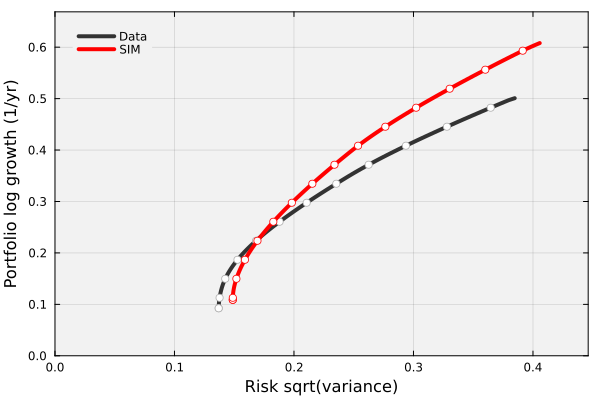

In [54]:
let

    # initialize -
    max_risk_value = results_array_data[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array_data[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_data = length(efficient_frontier_data); # how many portfolios did we recover?
    skip = 10;

    plot(results_array_data[:,1], results_array_data[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="Data", c=:gray20, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_data[1:skip:number_of_portfolios_data,1], results_array_data[1:skip:number_of_portfolios_data,2], 
        label="", c=:white, ms=4, msc=:gray69)

    max_risk_value = results_array_sim[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array_sim[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_sim = length(efficient_frontier_sim); # how many portfolios did we recover?
    plot!(results_array_sim[:,1], results_array_sim[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=18, label="SIM", c=:red, 
        xlim=(0.0, 1.1*max_risk_value), ylim = (0.0, 1.1*max_reward_value))
    scatter!(results_array_sim[1:skip:number_of_portfolios_sim,1], results_array_sim[1:skip:number_of_portfolios_sim,2], 
        label="", c=:white, ms=4, msc=:red)

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

end

> __What do you observe?__ The SIM efficient frontier (red) is rotated and shifted relative to the data-driven frontier (black). This rotation occurs because the SIM imposes a specific correlation structure where all asset correlations are driven by their market betas. The data-driven approach, in contrast, captures all pairwise correlations directly from historical data, including firm-specific relationships not explained by market movements alone.

### Reflection Questions
Before diving into the portfolio details, take a moment to think about what you observe in the efficient frontier plot above:

1. __Why do the two efficient frontiers differ?__ The SIM frontier is rotated and shifted relative to the data-driven frontier. What assumptions or simplifications in the single index model might cause this difference?
2. __Which approach is "correct"?__ Consider that the SIM assumes all covariance between assets comes through their relationship with the market (via $\beta_i\beta_j\sigma_m^2$), while the data-driven approach directly estimates pairwise covariances. What are the tradeoffs between model simplicity and capturing actual asset relationships?
3. __What does this mean for portfolio allocation?__ If the efficient frontiers differ, the optimal portfolio weights at any given risk or return level must also differ. How sensitive do you expect the asset allocations to be to these differences?

Let's explore these questions by examining the actual portfolio compositions in Task 3.
___

## Task 3: What's in a data-driven versus single index model portfolio?
The single index model efficient frontier is rotated and shifted relative to the data-driven portfolio (with the default tickers). Let's explore how this difference is reflected in the choices of the weights of the assets in the portfolio. To begin, specify a desired portfolio growth rate in the `desired_growth_rate` variable:

In [58]:
desired_growth_rate = 0.20; # select a desired *excess* return where both approaches have data

Next, let's (re)resolve the minimum variance problem for the data-driven and single-index models, assuming a `desired_growth_rate` value. Update the `problem_risk` and `problem_risk_sim` problem instances with the new `R` field, and then call the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) to resolve the optimization problem:

In [60]:
solution_data, solution_sim = let

    # initialize -
    problem_data.R = desired_growth_rate;
    problem_sim.R = desired_growth_rate;
    solution_data = nothing;
    solution_sim = nothing;
    
    try
        solution_data = solve(problem_data);
        solution_sim = solve(problem_sim);
    catch err
        # Uncomment below to see error message
        println("What the what? Something happened: $(err)");
    end

    (solution_data, solution_sim); # return
end;

`Unhide` the code block below to see how we constructed the portfolio allocation table for the data-driven and single-index model portfolios.

> __What do we expect to see?__: The data-driven and single-index model allocations are similar, where each non-zero allocation for the data-driven portfolio is preserved in the case of the single-index model. However, several minor differences between the two portfolios do not appear to be correlated with the $\beta$ of the ticker. 

So what do we see?

In [62]:
let
    ω_data = solution_data["argmax"];
    ω_sim = solution_sim["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i];
        ω_dataᵢ = ω_data[i];
        ω_simᵢ = ω_sim[i];
        row_data = (
            ticker = ticker,
            α = sim_model_parameters[ticker].alpha,
            β = sim_model_parameters[ticker].beta,
            w_data = round(ω_dataᵢ, digits=4) |> abs,
            w_sim = round(ω_simᵢ, digits=4) |> abs,
            Δ = round(ω_dataᵢ - ω_simᵢ, digits=4)
        );
        push!(table_df,row_data)
    end

    
    pretty_table(table_df, backend = :text,
         table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 -------- ------------ ---------- --------- --------- ---------
  ticker            α          β    w_data     w_sim         Δ 
  String      Float64    Float64   Float64   Float64   Float64 
 -------- ------------ ---------- --------- --------- ---------
    AAPL     0.106055    1.19459    0.1551    0.1768   -0.0217
    MSFT    0.0999256    1.15201    0.2525    0.2457    0.0068
    INTC    -0.148435    1.18427       0.0       0.0      -0.0
      MU    -0.053226    1.69527       0.0       0.0      -0.0
     AMD     0.127466    1.73915    0.0218       0.0    0.0218
    NVDA      0.34678    1.74926    0.1328    0.0824    0.0503
      GS   -0.0325528    1.31001       0.0       0.0       0.0
     BAC   -0.0545152    1.35942       0.0       0.0       0.0
     WFC   -0.0914062     1.2383       0.0       0.0      -0.0
       C    -0.133436    1.50075       0.0       0.0       0.0
       F    -0.192761    1.43356       0.0       0.0       0.0
      GM    -0.129065     1.4695       0.0       0.

___

## Summary
In this example, we constructed minimum variance portfolios using both data-driven covariance matrices and single index model parameters, demonstrating the practical application of SIM in portfolio optimization.

> __Key Takeaways:__
>
> * __SIM covariance construction:__ We built portfolio covariance matrices using $\operatorname{Cov}(g_i, g_j) = \beta_i\beta_j\sigma_m^2$ for $i \neq j$ and $\operatorname{Cov}(g_i, g_i) = \beta_i^2\sigma_m^2 + \sigma_{\epsilon_i}^2$, requiring estimation of only $N$ beta values plus $\sigma_m^2$ rather than $N(N+1)/2$ unique covariances for the data-driven approach.
> * __Efficient frontier comparison:__ We computed efficient frontiers using both methodologies, observing that the SIM-based frontier exhibited rotation and shift relative to the data-driven frontier while maintaining similar overall structure and risk-return relationships.
> * __Portfolio allocation patterns:__ We analyzed asset weights at equivalent return levels, finding that SIM-based portfolios preserved major allocation decisions from data-driven portfolios with minor weight adjustments that did not correlate directly with individual asset $\beta_i$ values.

The single index model provides a computationally efficient alternative to data-driven portfolio optimization while maintaining reasonable approximation of optimal portfolio allocations. 
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.